In [1]:
#Importing all nescessary libraries
import matplotlib.pyplot as plt
import numpy as np
from astropy import constants as c
import scipy.constants as si
import math
import pandas as pd
import scipy
from scipy import interpolate
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.interpolate import interpnd
from scipy.integrate import quad
from sympy import Symbol
import sympy as sp
from functools import partial
import sys
import matplotlib.image as img
from scipy.interpolate import griddata

from astropy.modeling import models
import astropy.units as u
from dust_extinction.parameter_averages import F99
from ebltable.ebl_from_model import EBL

import devesh_a3p2_directory.a3p2.a3p2.astro.cosmo
from devesh_a3p2_directory.a3p2.a3p2.constants import *

import sys
import time
import logging
import gzip
import astropy.io.fits as pyfits

        Time  Wavelength  LogTOTAL  LogSTELLA  LogNEBUL
0  2270600.0        91.0  25.60646   25.60646     -15.0
1  2270600.0        94.0  25.62327   25.62327     -15.0
2  2270600.0        96.0  25.63802   25.63802     -15.0
3  2270600.0        98.0  25.65265   25.65265     -15.0
4  2270600.0       100.0  25.67387   25.67387     -15.0


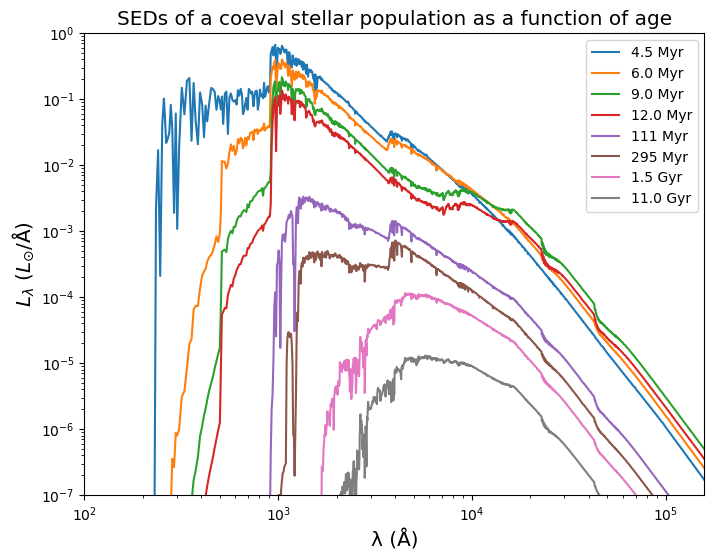

In [2]:
# Reading output from Starburst99 simulation, old for denoting luminosity before applying dust attenuation and new after applying dust attenuation
spectrumold = pd.read_csv('/Users/deveshchopra/ebl/final run_spectrum.csv', skiprows=0)  # with kroupa imf and initial mass being 100 solar mass
print(spectrumold.head())
awsold = spectrumold[spectrumold.Time == 2.270600e+06].Wavelength # all wavelengths from SB99
atsold = spectrumold[spectrumold.Wavelength == 91].Time # all time epochs from SB99

# Solar luminosity in ergs/s
lsun = c.L_sun.value * (10**7)

# Importing luminosity(erg/sec/A) and Wavelength column at specific epochs
def time(x):
    return spectrumold[spectrumold.Time == x]

def wl(x):
    return time(x)['Wavelength']

# Normalized to 10**6 solar masses as it was the initial mass taken
def norml(x):
    return ((10**time(x)['LogTOTAL']) / lsun) / 10**6

# Epoch labels for legend
epoch_labels = {
    4552100: "4.5 Myr",
    6012200: "6.0 Myr",
    9125900: "9.0 Myr",
    12053000: "12.0 Myr",
    111620000: "111 Myr",
    295550000: "295 Myr",
    1568900000: "1.5 Gyr",
    11000000000: "11.0 Gyr"
}

# Plotting the SEDs for different epochs
plt.figure(figsize=(8, 6))
for epoch in epoch_labels:
    plt.plot(wl(epoch), norml(epoch), label=epoch_labels[epoch])

# Set plot properties
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-7, 1)
plt.xlim(10**2, 10**5.2)
plt.xlabel('λ (Å)', size='x-large')
plt.ylabel(r'$L_\lambda$ ($L_{\odot}$/Å)', size='x-large')
plt.title('SEDs of a coeval stellar population as a function of age', size='x-large')
plt.legend(loc='upper right')
plt.savefig('SED')
plt.show()

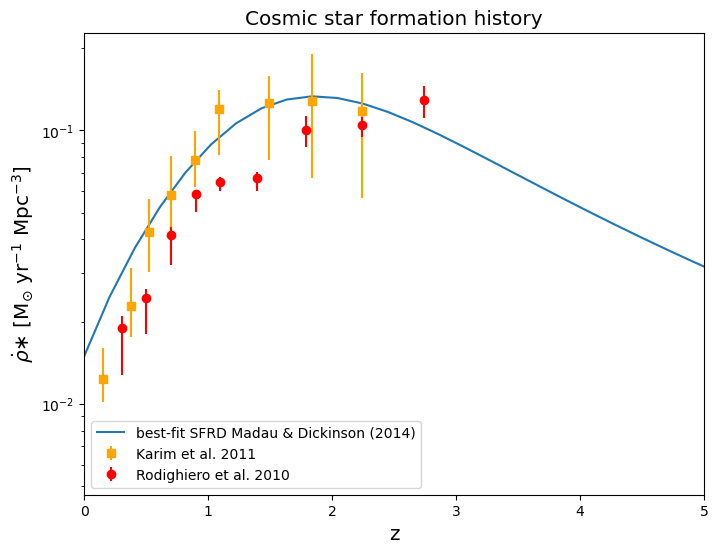

In [3]:
# Updated Starformation rate History(Madau and Dickinson 2014) as a function of redshift
ρo = 0.015  # Mo/yr/Mpc3

# Defining sfrd Mo/yr/Mpc3
def ρ(Z):
    return ρo * (((1 + Z) ** 2.7) / (1 + ((1 + Z) / 2.9) ** 5.6))  # Mo/yr/Mpc3

# Data from Karim et al. 2011, ApJ, 730, 61
ksfrh = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/karim sfrh.csv', header=None)
kz = ksfrh.iloc[:, 0]
ksfr = ksfrh.iloc[:, 1]

ksfrhue = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/karim sfrh upper error.csv', header=None)
ksfrhle = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/karim sfrh lower error.csv', header=None)

# Calculate errors and align with data points
ksfr_err = np.abs(ksfrhle.iloc[:, 1] - ksfr), np.abs(ksfrhue.iloc[:, 1] - ksfr)

# Data from Rodighiero
Rsfrh = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/Rodighiero sfrh.csv', header=None)
Rz = Rsfrh.iloc[:, 0]
Rsfr = Rsfrh.iloc[:, 1]

Rsfrhue = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/Rodighiero sfrh upper error.csv', header=None)
Rsfrhle = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/Rodighiero sfrh lower error.csv', header=None)

# Calculate errors and align with data points
Rsfr_err = np.abs(Rsfrhle.iloc[:, 1] - Rsfr), np.abs(Rsfrhue.iloc[:, 1] - Rsfr)

# Plotting et al. 2010
plt.figure(figsize=(8, 6))

# Plot the best-fit SFRD Madau & Dickinson (2014)
z_values = np.linspace(0, 10)
sfrd_values = [ρ(i) for i in z_values]
plt.plot(z_values, sfrd_values, label='best-fit SFRD Madau & Dickinson (2014)')

# Plot Karim et al. 2011 data with error bars
plt.errorbar(kz, ksfr, yerr=ksfr_err, fmt='s', color='orange', label='Karim et al. 2011')

# Plot Rodighiero et al. 2010 data with error bars
plt.errorbar(Rz, Rsfr, yerr=Rsfr_err, fmt='o', color='red', label='Rodighiero et al. 2010')

# Set plot properties
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('z', size='x-large')
plt.ylabel(r'$\dot{\rho}$∗ [M$_{\odot}$ yr$^{-1}$ Mpc$^{-3}$]', size='x-large')
plt.title('Cosmic star formation history', size='x-large')
plt.xlim(0, 5)
plt.legend()

plt.savefig('sfrd Madau')
plt.show()

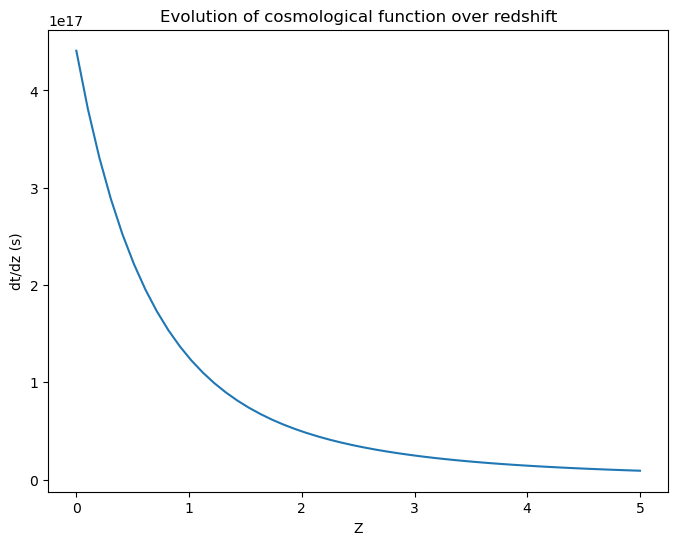

In [4]:
# Cosmological parameters using 737 cosmology
Ωr = 0
Ωm = 0.3
ΩΛ = 0.7
Ωk = 0
Ωo = Ωr + Ωm + ΩΛ + Ωk

def E(Z):
    return np.sqrt(Ωr * (1 + Z)**4 + Ωm * (1 + Z)**3 + Ωk * (1 + Z)**2 + ΩΛ)

# Defining dt/dz (the cosmological parameters enter our calculation through here)
def dtbydz(Z, Ho):
    return (1 / (Ho * (1 + Z) * E(Z))) * 3.086 * (10**19)  # s

# Calculate dt/dz for a range of redshifts
z_values = np.linspace(0, 5)
dt_dz_values = dtbydz(z_values, 70)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(z_values, dt_dz_values)
plt.xlabel('Z')
plt.ylabel('dt/dz (s)')
plt.title('Evolution of cosmological function over redshift')

plt.savefig('cosmological_function')
plt.show()

# Time as a function of redshift for 737 cosmology
def t(Z):
    return 14e9 * ((1 / (1 + Z))**1.5)

In [5]:
#Using parts of a3p2(https://github.com/mraue/a3p2) code and modifying
def read_ssp_sb99(datfile) :
    """
    Read simple stellar population model spectra from starburst 99 output:
    http://www.stsci.edu/science/starburst99/
    
    [erg s^-1 A^-1], 1E6 M_solar
    """
    d = np.loadtxt(datfile, skiprows=6)
    # Get unique time steps
    tt = d[:,0].tolist()
    tt.sort()
    unique = [x for i, x in enumerate(tt) if not i or x != tt[i-1]]
    t = np.asarray(unique)
    # Read spectra, store in data array
    l, dd, first = None, None, True
    for ts in t :
        dt = d[d[:,0] == ts, :]
        if first :
            l = dt[:,1]
            dd = dt[:, 3][:, np.newaxis]
            first = False
        else :
            dd = np.hstack([dd, dt[:, 3][:, np.newaxis]])
    dx = np.log10(si.c / l[::-1] / 1E-10) # log(frequency/Hz)
    dy = np.log10(t) # log(Time/yrs)
    dz = (dd[::-1] - 6. + np.log10(1E10 * si.c) - 2. * dx[:,np.newaxis])# log(em [erg/s/Hz/M_solar])
    # Sanity
    dz[np.invert(np.isfinite(dz))] = -43.
    return (dx, dy, dz, dd)

ssd = read_ssp_sb99('/Users/deveshchopra/downloads/Masters thesis/final run (1).spectrum')

erg_J = 1e-7
eV_J = 1.6e-19

#without a3p2
def apply_dust(d, ebv=.15, ebv2=None, ir_fac=1e9, ir_wave_start=5.5) :
    
    dx, dy, dz, dat = d
    # Resample data to encompass larger wavelength range
    logging.info('Extending wavelength range of SSP models for IR emission')
    dat_intp = scipy.interpolate.RectBivariateSpline(x=dx, y=dy, z=dz, kx=1, ky=1)
    dx_old = dx
    ir_lnu_min, ir_lnu_max = 11., 17.
    ir_lnu_nsteps = int((ir_lnu_max - ir_lnu_min) / ((dx_old[-1] - dx_old[0]) / len(dx_old)))
    logging.info('ir_lnu_min={0}, ir_lnu_max={1}, ir_lnu_nsteps={2}'.format(ir_lnu_min, ir_lnu_max, ir_lnu_nsteps))
    dx = np.linspace(ir_lnu_min, ir_lnu_max, ir_lnu_nsteps)
    xx = np.ones([len(dx), len(dy)]) * dx[:, np.newaxis]
    yy = np.ones([len(dx), len(dy)]) * dy[np.newaxis, :]
    dz = dat_intp.ev(xx.flatten(), yy.flatten()).reshape([len(dx), len(dy)])
    m = (dx < dx_old[0]) + (dx > dx_old[-1])
    dz[m] = -43.
    dat_intp = scipy.interpolate.RectBivariateSpline(x=dx, y=dy, z=dz, kx=1, ky=1)
   
    def att_kn2002(l) :
        return -.4 *  .68 * 3.2 * ((1. / l) - .35)
    
   # Calculate dust attenuation
    dz_att = np.copy(dz)
    dx_l = (si.c / (10. ** dx) * 1E6)
    
    if ebv2 :
        logging.info('Using two step dust emission a la KN02: E(B-V)_1 = {0}, E(B-V)_2 = {1}'.format(ebv, ebv2))
        m = dy <= np.log10(3E8)
        #dz_att[:, m] += (ebv * att_fm2007(dx_l))[:, np.newaxis]
        dz_att[:, m] += (ebv * att_kn2002(dx_l))[:, np.newaxis]
        #dz_att[:, m] += (-.4 *  0.68 * ebv * 3.2 * (1. / (si.c / (10. ** dx) * 1E6) - .35))[:, np.newaxis]
        m = dy > np.log10(3E8)
        #dz_att[:, m] += (ebv * att_fm2007(dx_l))[:, np.newaxis]
        dz_att[:, m] += (ebv2 * att_kn2002(dx_l))[:, np.newaxis]
        #dz_att[:, m] += (-.4 *  0.68 * ebv2 * 3.2 * (1. / (si.c / (10. ** dx) * 1E6) - .35))[:, np.newaxis]
    else :
        #dz_att += (ebv * att_fm2007(dx_l))[:, np.newaxis]
        dz_att += (ebv * att_kn2002(dx_l))[:, np.newaxis]
        #dz_att += (-.4 *  0.68 * ebv * 3.2 * (1. / (si.c / (10. ** dx) * 1E6) - .35))[:, np.newaxis]

    m = (dx < np.log10(13.6 * eV_J / si.h)) * (dx > np.log10(si.c / ir_wave_start / 1E-6))
    int1 = scipy.integrate.simps(
        np.transpose(10. ** dz_att[m, :] * (10. ** dx[m])[:, np.newaxis] * np.log(10.)),
        np.transpose(np.ones(dz_att[m, :].shape) * dx[m][:, np.newaxis])
        )
    
    # DEBUG
    # Double UV
    #m =  (dx > np.log10(si.c / ir_wave_start / 1E-6))
    # END DEBUG
    int2 = scipy.integrate.simps(
        np.transpose(10. ** dz[m, :] * (10. ** dx[m])[:, np.newaxis] * np.log(10.)),
        np.transpose(np.ones(dz[m, :].shape) * dx[m][:, np.newaxis])
        )
    int1 *= erg_J / c.L_sun.value
    int2 *= erg_J /c.L_sun.value
    l_dust_att = int2 - int1
    
    #DEBUG
    #l_dust_att[dy < 6.75] *= 2.
    #END DEBUG
    m = dx > np.log10(13.6 * eV_J / si.h)
    l_ion = scipy.integrate.simps(
        np.transpose(10. ** dz[m] * (10. ** dx[m])[:, np.newaxis] * np.log(10.)),
        np.transpose(np.ones(dz[m].shape) * dx[m][:, np.newaxis])
        ) *  erg_J / c.L_sun.value
    f_lya = .68
    ir_fac = 1. / ir_fac
    
    # Read IR SEDs from Chary & Elbaz 2001
    f = pyfits.open('/Users/deveshchopra/ebl/chary_elbaz.fits')
    d = f[1].data
    ir_l = d.field('LAMBDA')[0]
    ir_lnu = np.log10(si.c / ir_l[::-1] / 1E-6)
    ir_lf = np.log10(d.field('NULNUINLSUN')[0])
    x, y = ir_lf.shape
    ir_lf = ir_lf[::-1]  - ir_lnu[:, np.newaxis] + np.log10(ir_fac) + np.log10(c.L_sun.value * 1E7)              
    ir_lint = np.log10(d.field('LIR')[0]) + np.log10(ir_fac)
    # Calculate integrated IR emission from ir_wave_start to 1E3 micrometer
    m = (ir_lnu < np.log10(si.c / ir_wave_start / 1E-6)) * (ir_lnu > np.log10(si.c / 1E3 / 1E-6))
    ir_lint_alt = np.log10(
        scipy.integrate.simps(np.transpose(10. ** (ir_lf[m] - 12.)* (10. ** ir_lnu[m])[:, np.newaxis] * np.log(10.)),
                              np.transpose(np.ones(ir_lf[m].shape) * ir_lnu[m][:, np.newaxis]))
        * erg_J / c.L_sun.value
        ) + 12.

    ir_lint = ir_lint_alt
    ir_intp = scipy.interpolate.RectBivariateSpline(x=ir_lnu, y=ir_lint, z=ir_lf, kx=1, ky=1)

    ir_lnu_cube = np.ones(dz.shape) * dx[:, np.newaxis]
    ir_lint_cube = np.ones(dz.shape) *  np.log10((l_dust_att + l_ion * f_lya)[np.newaxis, :])

    ir_dz = ir_intp.ev(ir_lnu_cube.flatten(), ir_lint_cube.flatten()).reshape(dz.shape)

    # Cut off IR emission at wavelength ir_wave_start
    ir_dz[dx > np.log10(si.c / ir_wave_start / 1E-6)] = -43.

    # rescale IR emission for out of range spectra
    m = ir_lint_cube > ir_lint[-1]
    if np.any(m) :
        logging.info('IR emission: scaling up dust emission for {0} spectra'.format(np.sum(m) / len(dx)))
        ir_dz[m] += (ir_lint_cube[m] - ir_lint[-1])
    m = ir_lint_cube < ir_lint[0]
    if np.any(m) :
        logging.info('IR emission: scaling down dust emission for {0} spectra'.format(np.sum(m) / len(dx)))
        ir_dz[m] += (ir_lint_cube[m] - ir_lint[0])
        
    # Set emission to infrared + attenuated UV-O-NIR emission
    dz = np.log10(10. ** ir_dz + 10. ** dz_att)

    dat_intp = None
    dz_att = None
    ir_l, ir_lnu, ir_lf, d = None, None, None, None
    ir_lint, ir_intp = None, None
    ir_lnu_cube, ir_lint_cube, ir_dz = None, None, None
    f.close()
    
    return (dx, dy, dz, dat)

ad = apply_dust(ssd)

Mwavelength = (c.c.value/(10**ad[0])[::-1])*1e10
Mtime = 10**ad[1]

In [6]:
#Converting the data to adjust to this code
# Calculate k1 using broadcasting
k1 = 10**np.tile(ad[1],1725)

# Calculate k2 using broadcasting
k2 = []
for x in range(0, 1725):
    k2.append(((np.tile(Mwavelength[x],54))))

k2 = np.concatenate(k2).tolist()

adl = (ad[2] + 2. * ad[0][:,np.newaxis] + 6 - np.log10(1E10 * si.c))[::-1]

ad1 = np.concatenate(adl).tolist()

spectrumnew = pd.DataFrame({'Time':k1,'Wavelength':k2,'LogTOTAL':ad1})

#spectrumnew
awsnew = spectrumnew[spectrumnew.Time == spectrumnew.iat[93149,0]].Wavelength # all wavelengths from SB99
atsnew = spectrumnew[spectrumnew.Wavelength == spectrumnew.iat[0,1]].Time # all time epochs from SB99

In [7]:
# selecting data at any wavlenength from SB99 output
def wavelengthold(λ):
    return spectrumold[spectrumold.Wavelength == λ]

#Converting Lλ to Lν
def Lνold(λ):
    return (((10**wavelengthold(λ).LogTOTAL))*(λ**2)/(3*(10**18)))/(10**6)   #erg/Mo

#to include dust attenuation
#defining average extinction curve
def A(λ) :
    E = 0.15  #E(B-V),color index/ color of dust attenuation
    R = 3.2
    return 0.68 * E * R * ((10000 / λ) - 0.35)  #λ in micro meter
def g(λ):
    if λ<1e6/35:
        return (10**(-0.4*A(λ)))
    else:
        return 1

#interpolation only at SB99 wavelengths
def Lνiold(λ):
    return interp1d(atsold, Lνold(λ), bounds_error=False, fill_value="extrapolate")

#Lν at all wavelengths
awsold = np.array(awsold)
Lνawsold = np.array([Lνold(awsold) for awsold in awsold])

#interpolation of Lν for any wavelength
def Lνwiold(λ):
    XX = np.array([λ])
    YY = []
    for i in range(Lνawsold.shape[1]):
        f = scipy.interpolate.UnivariateSpline(awsold, Lνawsold[:, i],s=0,k=1)
        for j in range(len(XX)):
            YY = np.append(YY,f(XX[j]))
    return YY

#interpolation of Lν(Z,λ) as a function of redshifts and wavelengths
def Lνifold(Z,λ):
    intp = scipy.interpolate.UnivariateSpline(atsold,Lνwiold(λ),s=0,k=1)
    return intp

#integrating Lν to get Eν
Zm = 5 #redshift where star formation begins
def Eνold(Z,λ,Ho):
    L = Lνifold(Z,λ)
    def i(Zp,Z,Ho):
        return L((t(Z))-t(Zp))*g(λ)*ρ(Zp)*dtbydz(Zp,Ho)/3.154e7  #with g(λ) = 10**-0.4Aλ
    return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]

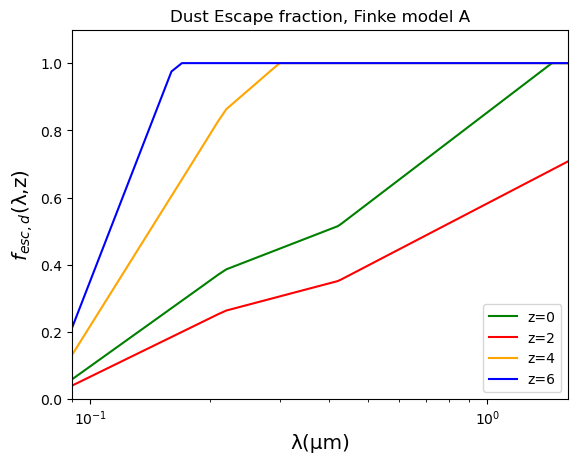

In [8]:
#Defining dust attenuation model according to Finke et al. 2022
#wavelength in microns
def Az(Z):
    md = 1.52
    nd = 0.35
    pd = 4.12
    qd = 5.89
    return md*((1+Z)**nd)/(1+(((1+Z)/pd)**qd))

#model A parameters of finke
[fesc1,fesc2,fesc3,fesc4,fesc5,l1,l2,l3,l4,l5] = [1.88,2.18,2.93,3.93,8.57,0.15,0.167,0.218,0.422,2.0] #microns

def fescdA(λ):
    if λ <= l2:
        return fesc2 + (fesc2 - fesc1)/(np.log10(l2) - np.log10(l1))*(np.log10(λ) - np.log10(l2))
    if l2 < λ <= l3:
        return fesc3 + (fesc3 - fesc2)/(np.log10(l3) - np.log10(l2))*(np.log10(λ) - np.log10(l3))
    if l3 < λ <= l4:
        return fesc4 + (fesc4 - fesc3)/(np.log10(l4) - np.log10(l3))*(np.log10(λ) - np.log10(l4))       
    if l4 < λ:
        return fesc5 + (fesc5 - fesc4)/(np.log10(l5) - np.log10(l4))*(np.log10(λ) - np.log10(l5))
    
def fescdAf(λ,Z):
        k = (fescdA(λ)/fescdA(0.1500))*(10**(-0.4*Az(Z)))
        if k<=1:
            return k
        else:
            return 1
        
# Eqn 13 Finke redshift dependence
z_values = np.linspace(0.01, 100, 10000)
fescdfz0 = np.array([fescdAf(l, 0) for l in z_values])
fescdfz2 = np.array([fescdAf(l, 2) for l in z_values])
fescdfz4 = np.array([fescdAf(l, 4) for l in z_values])
fescdfz6 = np.array([fescdAf(l, 6) for l in z_values])

# Plotting
plt.plot(z_values, fescdfz0, label='z=0', color='g')
plt.plot(z_values, fescdfz2, label='z=2', color='r')
plt.plot(z_values, fescdfz4, label='z=4', color='orange')
plt.plot(z_values, fescdfz6, label='z=6', color='blue')

plt.xlabel('λ(μm)', size='x-large')
plt.ylabel('$f_{esc,d}$(λ,z)', size='x-large')
plt.xscale('log')
plt.title('Dust Escape fraction, Finke model A')
plt.xlim(0.09,1.6)
plt.ylim(0,1.1)
plt.legend()
plt.savefig('dust extinction model A')

In [9]:
#modifing to get ir emission after applying dust attenuation

# selecting data at any wavlenength from SB99 output
def wavelengthnew(λ):
    return spectrumnew[spectrumnew.Wavelength == λ]

#Converting Lλ to Lν
def Lνnew(λ):
    return (((10**wavelengthnew(λ).LogTOTAL))*(λ**2)/(3*(10**18)))/(10**6)   #erg/Mo

#interpolation only at SB99 wavelengths
def Lνinew(λ):
    return interp1d(atsnew, Lνnew(λ), bounds_error=False, fill_value="extrapolate")

#Lν at all wavelengths
awsnew = np.array(awsnew)
Lνawsnew = np.array([Lνnew(awsnew) for awsnew in awsnew])

#interpolation of Lν for any wavelength
def Lνwinew(λ):
    XX = np.array([λ])
    YY = []
    for i in range(Lνawsnew.shape[1]):
        f = scipy.interpolate.UnivariateSpline(awsnew, Lνawsnew[:, i],s=0,k=1)
        for j in range(len(XX)):
            YY = np.append(YY,f(XX[j]))
    return YY

#interpolation of Lν(Z,λ) as a function of redshifts and wavelengths
def Lνifnew(Z,λ):
    intp = scipy.interpolate.UnivariateSpline(atsnew,Lνwinew(λ),s=0,k=1)
    return intp

#integrating Lν to get Eν
Zm = 5 #redshift where star formation begins
def Eνnew(Z,λ,Ho):
    L = Lνifnew(Z,λ)
    def i(Zp,Z,Ho):
        return L((t(Z))-t(Zp))*ρ(Zp)*dtbydz(Zp,Ho)/3.154e7  #with g(λ) = 10**-0.4Aλ
    return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]

In [10]:
#Performing integration over luminosity to get emissivity for the range without dust attenuation
#defining integrand for νIν calculation
def Izold(Zp,Z,λ,Ho):
    return Eνold(Zp,λ*((1+Z)/(1+Zp)),Ho)*dtbydz(Zp,Ho)

#using simpsons integration to get νIν
def sfsold(Z,λ,Ho):
    return [Izold(Zp,Z,λ,Ho) for Zp in np.linspace(Z,Zm)]
def siold(Z,λ,Ho):
    return np.array(3/(4*np.pi*λ*1e39))*integrate.simpson(sfsold(Z,λ,Ho),np.linspace(Z,Zm))

#After applying dust attenuation
#defining integrand for νIν calculation
def Iznew(Zp,Z,λ,Ho):
    return Eνnew(Zp,λ*((1+Z)/(1+Zp)),Ho)*dtbydz(Zp,Ho)

#using simpsons integration to get νIν
def sfsnew(Z,λ,Ho):
    return [Iznew(Zp,Z,λ,Ho) for Zp in np.linspace(Z,Zm)]
def sinew(Z,λ,Ho):
    return np.array(3/(4*np.pi*λ*1e39))*integrate.simpson(sfsnew(Z,λ,Ho),np.linspace(Z,Zm))

#calculate the ebl over complete range
ebl737z0old = [siold(0,λ,70) for λ in np.logspace(np.log10(1e3),np.log10(1e6/35))]
ebl737z0new = [sinew(0,λ,70) for λ in np.logspace(np.log10(1e6/35),np.log10(1e7))]
eblf = np.concatenate([ebl737z0old,ebl737z0new])
npf = np.concatenate([np.logspace(np.log10(1e3),np.log10(1e6/35)),np.logspace(np.log10(1e6/35),np.log10(1e7))])

/var/folders/q1/lnzb6xf54vb5pw52pxtbc39c0000gn/T/ipykernel_68168/3132595176.py:50: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]
/var/folders/q1/lnzb6xf54vb5pw52pxtbc39c0000gn/T/ipykernel_68168/3132595176.py:50: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]


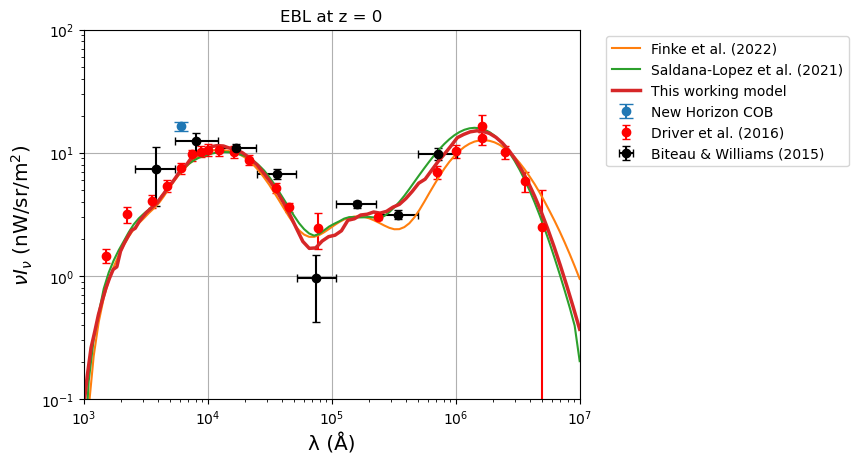

In [11]:
#Plotting the final EBL output for this working model
# Data from driver et al. 2016
debld = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/ebl driver et al. 2016.csv', header=None)
dl = debld.iloc[:, 0]
debl = debld.iloc[:, 1]

deblue = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/ebl driver et al. 2016 upper error.csv', header=None)
deblle = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/ebl driver et al. 2016 lower error.csv', header=None)
deblle.loc[21, 1] = 0.0004

deblemin = debl - deblle.iloc[:, 1]
deblemax = deblue.iloc[:, 1] - debl

debl_err = [deblemin, deblemax]

#Rodighiero
bwebld = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/ebl bw 2015.csv', header=None)
bwl = bwebld.iloc[:, 0]
bwebl = bwebld.iloc[:, 1]

bweblue = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/ebl bw 2015 upper error.csv', header=None)
bweblle = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/ebl bw 2015 lower error.csv', header=None)

bwlre = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/ebl bw 2015 right error.csv', header=None)
bwllfe = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/ebl bw 2015 left error.csv', header=None)

bwebleminy = bwebl - bweblle.iloc[:, 1]
bweblemaxy = bweblue.iloc[:, 1] - bwebl

bwebl_erry = [bwebleminy, bweblemaxy]

bwleminx = 1e4 * bwl - 1e4 * bwllfe.iloc[:, 0]
bwlemaxx = 1e4 * bwlre.iloc[:, 0] - 1e4 * bwl

bwl_errx = [bwleminx, bwlemaxx]

lmu = np.logspace(-1,3.,100)

eblsl = EBL.readmodel('saldana-lopez')
nuInusl = eblsl.ebl_array(0,lmu)

eblfin = EBL.readmodel('finke2022')
nuInufin = eblfin.ebl_array(0,lmu)

ebldom = EBL.readmodel('dominguez')
nuInudom = ebldom.ebl_array(0,lmu)


#plotting martin raue ebl data
eblmrz0 = pd.read_csv('/Users/deveshchopra/Downloads/Masters thesis/mrebl.csv', skiprows=0)
eblmrwav = eblmrz0.iloc[:,0]
eblmrnuInu = eblmrz0.iloc[:,1]

xNH= 0.608316410892*1e4
yNH = 16.35011377
yerror_upperNH = 17.8004667445-yNH
yerror_lowerNH = yNH - 14.9124854142
errorsNH =[ [yerror_lowerNH],[yerror_upperNH]]
plt.errorbar(xNH,yNH,yerr=errorsNH, fmt = 'o',label="New Horizon COB",solid_capstyle='projecting', capsize=5) 

plt.errorbar(dl*1e4, debl, yerr=debl_err, fmt='o', color='red',capsize=3,label='Driver et al. (2016)')
plt.errorbar(bwl*1e4, bwebl, xerr=bwl_errx, yerr=bwebl_erry, fmt='o', color='black',capsize=3,label='Biteau & Williams (2015)')

plt.loglog(lmu*1e4,nuInufin,label='Finke et al. (2022)')
plt.loglog(lmu*1e4,nuInusl,label='Saldana-Lopez et al. (2021)')

plt.loglog(npf,eblf,label='This working model', lw=2.5)

plt.xlim(1e3,1e7)
plt.ylim(0.1,100)
plt.gca().set_xlabel('λ (Å)',size = 'x-large')
plt.gca().set_ylabel(r'$\nu I_\nu $ (nW/sr/m$^2$)',size = 'x-large')
plt.title('Z=0')
plt.title('EBL at z = 0')
plt.grid()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

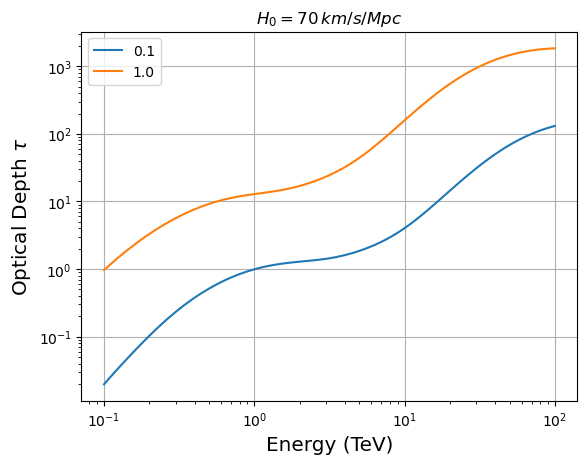

In [12]:
#optical depth calculation for the EBL obtained for this working model
ebl =  EBL.readascii("/Users/deveshchopra/ebl/ebl@Ho_70.out")
ebl._model = "my_model"

h0 = 70.
ETeV = np.logspace(-1,2,100)

z = np.arange(0.,1.2,0.2)
lmu = np.logspace(-1,3.,100)
nuInu = ebl.ebl_array(z,lmu)

zz = [0.1,1.]
for z0 in zz:
    tau = ebl.optical_depth(z0,ETeV,H0 = h0)
    plt.loglog(ETeV, tau, label = z0)
    
plt.legend()
plt.xlabel('Energy (TeV)',size = 'x-large')
plt.ylabel(r'Optical Depth $\tau$',size = 'x-large')
plt.grid()
plt.title(r'$H_0=70\, km/s/Mpc$')
#fig.savefig("output.png", dpi=300)
plt.show()

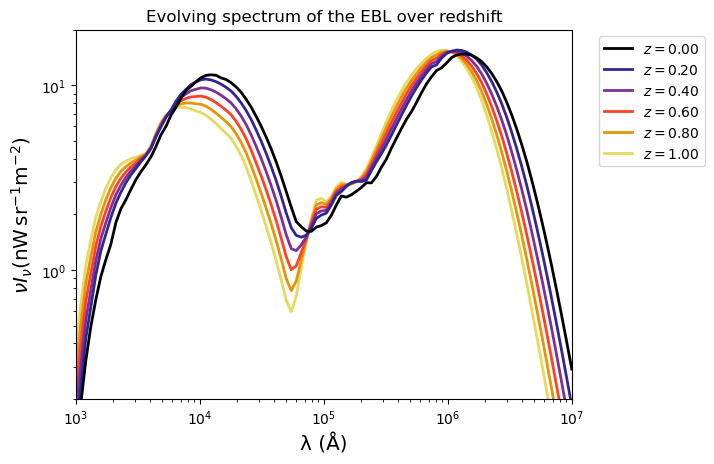

In [13]:
#Plotting evolution of EBL for this working model over redshift
for i,zz in enumerate(z):
    plt.loglog(lmu*1e4,nuInu[i],
              ls = '-', color = plt.cm.CMRmap(i / float(len(z))),
               lw = 2.,
              label = '$z = {0:.2f}$'.format(zz), 
              zorder= -1 * i)
    
plt.gca().set_xlabel('Wavelength ($\mu$m)',size = 'x-large')
plt.xlabel('λ (Å)',size = 'x-large')
plt.gca().set_ylabel(r'$\nu I_\nu (\mathrm{nW}\,\mathrm{sr}^{-1}\mathrm{m}^{-2})$',size = 'x-large')
plt.legend(loc = 'lower center', ncol = 2)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title('Evolving spectrum of the EBL over redshift')
plt.xlim(1e3,1e7)
plt.ylim(0.2,20)
plt.savefig('EBL evolution')
plt.show()